# Best Keras Pre-Trained Model for Image Classification
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stephenleo/keras-model-selection/blob/main/keras_model_selection.ipynb)

When in doubt, use data to decide!

This post will use a data-driven approach in Python to find out the best Keras Pre-Trained model for the `cats_vs_dogs` dataset. This post and the code provided will also help you choose the best Pre-Trained model for your problem's dataset easily.

## Background
Transfer learning is a technique in machine learning where we can take a model developed on one task and use it as a starting point in some other similar but different tasks. Transfer learning is extremely popular in Deep Learning since the "transfer" of knowledge from one "parent" model to a "child" model means that the "child" model can be trained to high accuracies with a much smaller dataset compared to the "parent" model. You can find more details about Transfer Learning at this excellent [Medium post](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)

High-level Deep Learning frameworks like TensorFlow and Pytorch have made it incredibly easy to leverage the power of Transfer learning by including several pre-trained models within the package itself. For example, the [TensorFlow Keras API](https://www.tensorflow.org/api_docs/python/tf/keras) includes 18 highly advanced model architectures pre-trained on the ["ImageNet"](https://en.wikipedia.org/wiki/ImageNet) dataset. You can think of "ImageNet" like the SAT of image classification datasets.

Most Image Classification Deep Learning tasks today will start by downloading one of these 18 pre-trained models, modify the model slightly to suit the task on hand, and train only the custom modifications while freezing the layers in the pre-trained model. This approach gives very high accuracy on real-world image classification tasks since "ImageNet" is a collection of many real-world images.

However, choosing which of the 18 pre-trained models to use is not always an exact science. Many developers stick to the models they are familiar with and gave them good results in the past. As a Data Scientist, I wondered whether there is a better, data-driven approach to selecting a pre-trained model, free from personal biases. Indeed there is! The rest of this post talks about my process with code you can directly use in your projects.

## Criteria for selecting models
In general, there are two competing criteria while doing any machine learning task in the industry:
1. Accuracy of the model: Higher Better
2. Speed of Model Training and Predictions: Faster Better

The two criteria are pretty straightforward. We want the model that gives us the highest accuracy on validation data since it can make useful predictions. We also want the model to train and predict as fast as possible because, in production, we might need to serve hundreds or thousands of predictions every second. 

Simple enough? Well, like everything in life, we can't have our cake and eat it too! In general, to get higher accuracy, we need to use a "deeper" or larger model. But a larger model has many more parameters that make it slower to execute. We can see the tradeoff between the accuracy and size/number of operations of the model from the below graph [Reference](https://arxiv.org/pdf/1810.00736.pdf).

![accuracy vs model size](images/acc_vs_size.png "Image Classification Accuracy vs Model Size")

So, this is a balance we need to strike. For most of the Deep Learning deployments in the industry, we choose the smallest model that provides us with good enough accuracy. Thus, we need to experiment among many available models to pick the one that meets these criteria.

On a side note, if you only care about achieving the highest accuracy no matter the impact to speed, then your approach could be to combine all these models using ensembling techniques! Indeed, ensembling is quite popular in academia and ML competitions.

## Code
My approach is straightforward, as shown in the image below. We will use Python to find all the pre-trained models in Keras and then loop over them one by one. We'll train the models on the TensorFlow [cats_vs_dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset in this post. You can replace it with any other dataset including your own custom dataset.

![steps to choose the best pre-trained Keras model](images/steps.png "Steps to choose the best pre-trained Keras model")

### Step 1
The first step is to import the necessary packages. If you lack these packages, you can install them using `pip install <package-name>.` We'll also set a `batch_size` for subsequent model training. Since I'm using a low-cost GPU, I'll put a small batch_size of 32 only.

In [1]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm

# Set batch size for training and validation
batch_size = 32

### Step 2
Automatically get a list of all available pre-trained models from Keras by listing all the functions inside `tf.keras.applications`. Since each model is instantiated by calling a function from `tf.keras.aplications`, when we list all the functions within this module by using `inspect.isfunction` we get a list of all the models. As of this writing, in [Tensorflow 2.2](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/applications) there are a total of 18 models that we can use. You can add any other custom pre-trained models into the experiments by manually adding elements into the `model_dictionary` as well by following the syntax 
`model_dictionary["new_model_name"] = new_model_function()`, where `new_model_function()` should return the custom pre-trained model without the final output `Dense` layer. The model's input shape should be (224,224,3) if you don't want to change any other code below.

In [2]:
# List all available models
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

### Step 3
Download some images to run the experiment. You should modify this step to load your data when you run the experiment for your use case.

In [3]:
# Download the training and validation data
(train, validation), metadata = tfds.load('cats_vs_dogs', split=['train[:70%]', 'train[70%:]'], 
                                          with_info=True, as_supervised=True)

# Number of training examples and labels
num_train = len(list(train))
num_validation = len(list(validation))
num_classes = len(metadata.features['label'].names)
num_iterations = int(num_train/batch_size)

# Print important info
print(f'Num train images: {num_train} \
        \nNum validation images: {num_validation} \
        \nNum classes: {num_classes} \
        \nNum iterations per epoch: {num_iterations}')

Num train images: 16283         
Num validation images: 6979         
Num classes: 2         
Num iterations per epoch: 508


### Step 4
Preprocess the input images. Some pre-trained models require images to be of size (224,224,3) while some require (331,331,3). We use this step to prepare both sizes of images and normalize them by dividing each pixel by 255. We also one-hot encode the labels so that we can use `categorical_crossentropy` loss during training.

In [4]:
def normalize_img(image, label, img_size):
    # Resize image to the desired img_size and normalize it
    # One hot encode the label
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    label = tf.one_hot(label, depth=num_classes)
    return image, label

def preprocess_data(train, validation, batch_size, img_size):
    # Apply the normalize_img function on all train and validation data and create batches
    train_processed = train.map(lambda image, label: normalize_img(image, label, img_size))
    train_processed = train_processed.batch(batch_size).repeat()

    validation_processed = validation.map(lambda image, label: normalize_img(image, label, img_size))
    validation_processed = validation_processed.batch(batch_size)

    return train_processed, validation_processed

# Run preprocessing
train_processed_224, validation_processed_224 = preprocess_data(train, validation, batch_size, img_size=[224,224])
train_processed_331, validation_processed_331 = preprocess_data(train, validation, batch_size, img_size=[331,331])

### Step 5
Loop over each model by downloading the pre-trained model without the output layers and freeze the weights. We then construct an empty `Sequential` model and first add the pre-trained model to it. We then add a single output Dense layer with `softmax` activation and compile it with `categorical_crossentropy` loss. Finally, we train the model by calling `model.fit` for `3 epochs`. We log the number of parameters (size of the model) and each model's final accuracy into a dictionary to visualize the results. If you get the following error during the model download `AttributeError: 'str' object has no attribute 'decode'`, just install a lower version of `h5py` [[source]](https://github.com/tensorflow/tensorflow/issues/44467)

```
pip uninstall h5py
pip install h5py<'3.0.0'
```

The whole process takes ~3 hours on an `n1-standard-4`(4 vCPUs, 15 GB RAM) with one `NVIDIA Tesla T4` GPU on Google Cloud Platform.

In [ ]:
# Loop over each model available in Keras
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}
for model_name, model in tqdm(model_dictionary.items()):
    # Special handling for "NASNetLarge" since it requires input images with size (331,331)
    if 'NASNetLarge' in model_name:
        input_shape=(331,331,3)
        train_processed = train_processed_331
        validation_processed = validation_processed_331
    else:
        input_shape=(224,224,3)
        train_processed = train_processed_224
        validation_processed = validation_processed_224

    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
    pre_trained_model.trainable = False

    # custom modifications on top of pre-trained model
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    history = clf_model.fit(train_processed, epochs=3, validation_data=validation_processed, 
                            steps_per_epoch=num_iterations)

    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])

### Step 6
Let's visualize the results by converting it to a DataFrame and sorting in ascending order for `num_model_params` since our goal is to select the smallest model with good enough accuracy. In this example, the `MobileNet` model already provides `97%` accuracy, so we can use this model directly. `MobileNetV2` and `NASNetMobile` are two other models we can consider for fine tuning experiments. In case the accuracy of our selected model is still insufficient, we can experiment by fine-tuning this selected model further, adding data augmentation, etc. We will apply the typical Deep Learning model improvement experiments on a model that is already proven to be close to our requirements. 

In [12]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(model_benchmarks)
benchmark_df.sort_values('num_model_params', inplace=True) # sort in ascending order of num_model_params column
benchmark_df.to_csv('benchmark_df.csv', index=False) # write results to csv file
benchmark_df

,model_name,num_model_params,validation_accuracy
0,MobileNetV2,2257984,0.947557
1,MobileNet,3228864,0.977361
2,NASNetMobile,4269716,0.975355
3,DenseNet121,7037504,0.927354
4,DenseNet169,12642880,0.955724
5,VGG16,14714688,0.910732
6,DenseNet201,18321984,0.941969
7,VGG19,20024384,0.894827
8,Xception,20861480,0.955008
9,InceptionV3,21802784,0.985958


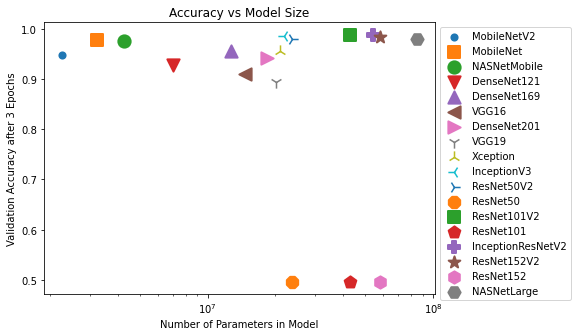

In [7]:
# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))
for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Validation Accuracy after 3 Epochs')
plt.title('Accuracy vs Model Size')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left'); # Move legend out of the plot

## Conclusion
In conclusion, I've presented a data-driven approach to choose the most suitable model from among a group of pre-trained models in the Tensorflow Keras API. In most industrial applications, we would select the model with the least number of parameters that provided good enough accuracy for further exploration. We can easily extend this approach to include other models not offered by Keras by manually adding items into the `model_dictionary` in [Step 2](#Step-2). 

Finally, extensive experimentation and data-driven decision making are the keys to success in all Machine Learning applications. I hope this post stimulates you to think of ways to make more data-driven decisions in your daily work. 

- You can find all the code used in this post at [GitHub](https://github.com/stephenleo/keras-model-selection/blob/main/keras_model_selection.ipynb). 
- You can also use Google Colab to directly run the code without any setup. Just remember to go to Edit --> Notebook Settings and select a `GPU` Hardware Accelerator: 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stephenleo/keras-model-selection/blob/main/keras_model_selection.ipynb)

Please give me a like if you found this post useful. Please also check out my YouTube channel for video content: [https://youtube.com/agnidata](https://youtube.com/agnidata)

Thank you for reading!